In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from xgboost import XGBClassifier


In [28]:
X_full = pd.read_csv('./dataset_Caso_1.csv')
y = X_full.target
X_full.drop(['target'], axis=1, inplace=True)

# Oversampling
Se intentó hacer oversampling de los datos con target = 1, pero no afecto en nada el resultado por lo que se descartó.

In [29]:
def augment_data(X_train, y_train, copies_amount = 99):
    #Augments the training data by replicating rows where y_train is 1.

    augmented_X = []
    augmented_y = []

    for i in range(len(y_train)):
        augmented_X.append(X_train.iloc[i])
        augmented_y.append(y_train.iloc[i])
        if y_train.iloc[i] == 1:
            for _ in range(copies_amount):  # Add copies
                augmented_X.append(X_train.iloc[i])
                augmented_y.append(y_train.iloc[i])

    # Create new DataFrames from the augmented data
    augmented_X_train = pd.DataFrame(augmented_X, columns=X_train.columns)
    augmented_y_train = pd.Series(augmented_y)

    return augmented_X_train, augmented_y_train

# Pre-procesamiento
## Normalización
No se normalizó los datos ya que al modelo elegido casi no le afecta debido a que está compuesto por árboles.

## One Hot Encoding
Se transformó las columnas de tipo categóricas x3 y x4 con one hot encoding.

# Cross-validation
Se utilizó validación cruzada para obtener las métricas de desempeño, ya que hay pocos datos con target = 1, lo que provoca que los resultados varíen significativamente dependiendo del conjunto de datos elegido para la evaluación.

Fold 1
Count Valid fold 1:  6


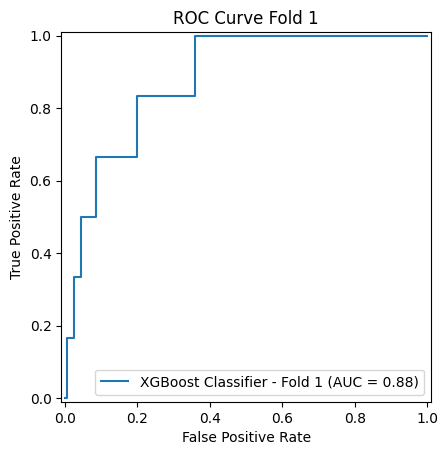

Fold 2
Count Valid fold 2:  6


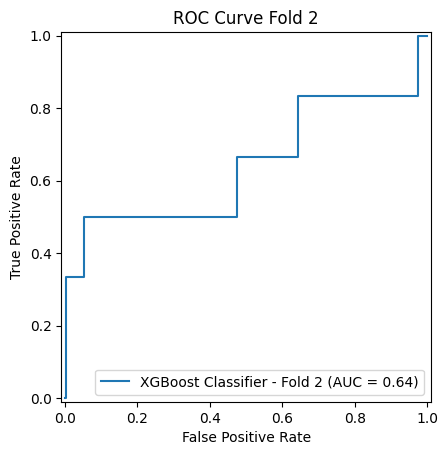

Fold 3
Count Valid fold 3:  4


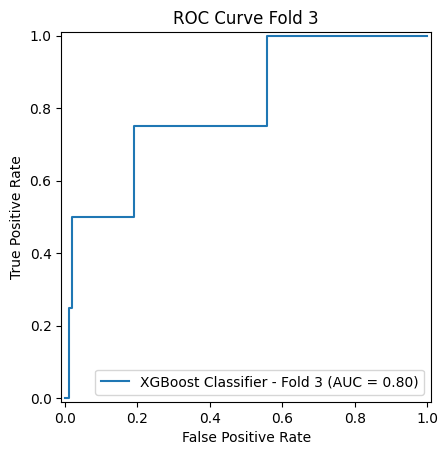

Fold 4
Count Valid fold 4:  2


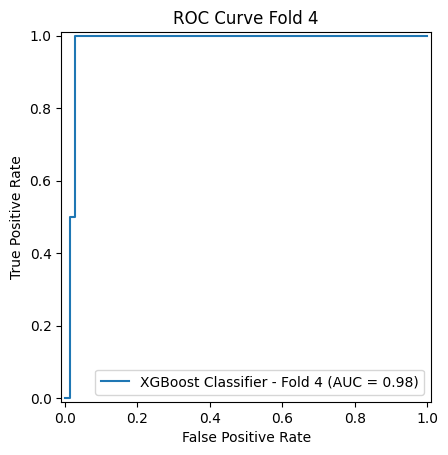

Fold 5
Count Valid fold 5:  4


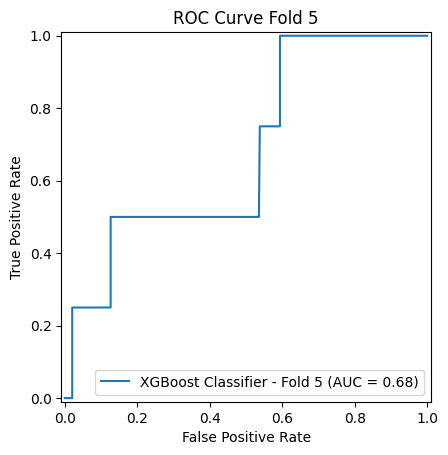

ROC AUC scores for each fold train: [1.0, 1.0, 1.0, 1.0, 1.0]
ROC AUC scores for each fold validation: [0.8807106598984772, 0.6417089678510999, 0.8049242424242425, 0.978643216080402, 0.6808712121212122]
F1 scores for each fold validation: [0.0, 0.0, 0.0, 0.0, 0.0]
Average ROC AUC score train: 1.0
Average ROC AUC score validation: 0.7973716596750867
Average F1 score validation: 0.0


In [30]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

roc_auc_scores_train = []
roc_auc_scores_valid = []
f1_score_valid = []

for fold, (train_index, valid_index) in enumerate(kf.split(X_full)):
    print(f"Fold {fold+1}")
    X_train, X_valid = X_full.iloc[train_index], X_full.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # One-hot encoding
    X_train = pd.get_dummies(X_train)
    X_valid = pd.get_dummies(X_valid)
    X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

    # Oversampling
    #X_train, y_train = augment_data(X_train, y_train)

    # Model
    model = XGBClassifier(random_state=0)
    model.fit(X_train, y_train)

    # AUC train
    preds_train = model.predict_proba(X_train)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_train, preds_train)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_scores_train.append(roc_auc)

    # AUC validation
    preds_valid = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, preds_valid)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_scores_valid.append(roc_auc)

    # F1 score validation
    #y_pred = model.predict(X_valid)
    y_pred = (preds_valid >= 0.5).astype(int)
    f1 = metrics.f1_score(y_valid, y_pred)
    f1_score_valid.append(f1)

    print(f'Count Valid fold {fold+1}: ',sum(y_valid))

    # Display ROC
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name=f'XGBoost Classifier - Fold {fold+1}')
    display.plot()
    plt.title(f"ROC Curve Fold {fold+1}")
    plt.show()



print(f"ROC AUC scores for each fold train: {roc_auc_scores_train}")
print(f"ROC AUC scores for each fold validation: {roc_auc_scores_valid}")
print(f"F1 scores for each fold validation: {f1_score_valid}")
print(f"Average ROC AUC score train: {sum(roc_auc_scores_train)/len(roc_auc_scores_train)}")
print(f"Average ROC AUC score validation: {sum(roc_auc_scores_valid)/len(roc_auc_scores_valid)}")
print(f"Average F1 score validation: {sum(f1_score_valid)/len(f1_score_valid)}")
